In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
##Remote sensing data:

# df_rs = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_remotedata.csv')
##Above: needs to be merged with biomass data (df_sum)
# df1 = pd.merge(df_rs, df_sum, how = 'right')

dfv = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_yr.csv')
dfw = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_octnov.csv')
dfx = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_augoct.csv')
dfy = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_sepoct.csv')
dfz = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_oct.csv')

dfv.rename(
    columns={
        'ndvi':'ndvi_yr','savi':'savi_yr','wdrvi5':'wdrvi5_yr','nd_r_g':'nd_r_g_yr', 'nd_g_b':'nd_g_b_yr',
        'nd_swir2_nir':'nd_swir2_nir_yr', 'nd_swir2_r':'nd_swir2_r_yr'
    }, inplace=True
)

dfw.rename(
    columns={
        'ndvi':'ndvi_octnov','savi':'savi_octnov','wdrvi5':'wdrvi5_octnov','nd_r_g':'nd_r_g_octnov', 'nd_g_b':'nd_g_b_octnov',
        'nd_swir2_nir':'nd_swir2_nir_octnov', 'nd_swir2_r':'nd_swir2_r_octnov'
    }, inplace=True
)

dfx.rename(
    columns={
        'ndvi':'ndvi_augoct','savi':'savi_augoct','wdrvi5':'wdrvi5_augoct','nd_r_g':'nd_r_g_augoct', 'nd_g_b':'nd_g_b_augoct',
        'nd_swir2_nir':'nd_swir2_nir_augoct', 'nd_swir2_r':'nd_swir2_r_augoct'
    }, inplace=True
)

dfy.rename(
    columns={
        'ndvi':'ndvi_sepoct','savi':'savi_sepoct','wdrvi5':'wdrvi5_sepoct','nd_r_g':'nd_r_g_sepoct', 'nd_g_b':'nd_g_b_sepoct',
        'nd_swir2_nir':'nd_swir2_nir_sepoct', 'nd_swir2_r':'nd_swir2_r_sepoct'
    }, inplace=True
)

df9 = pd.merge(dfw, dfv, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

df8 = pd.merge(dfx, dfy, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

df0 = pd.merge(df9, df8, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')              
               
df1 = pd.merge(df0, dfz, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

# df0 = pd.merge(dfx, dfy, on = ['Latitude', 'Longitude', 'Plant_Biomass', 'Year'], how = 'left')
# df1 = pd.merge(dfz, df0, on = ['Latitude', 'Longitude', 'Plant_Biomass', 'Year'], how = 'left')

df1['ident'] = df1['ndvi'] * df1['ndvi_augoct'] * df1['ndvi_sepoct']

display(df1)

for col in df1.columns:
    print(col)

In [ ]:
for col in df1.columns:
    print(col)

In [ ]:
##Modeling
df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df1.csv')

df1.rename(columns={'elevation':'Elevation'}, inplace=True)
# df1 = df1[df1['ident'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1)] ##TIDAL FILTERING STEP!

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

df1['Date'] = pd.to_datetime(df1.Date, format='%m/%d/%Y')
df1['DOY'] = df1['Date'].dt.strftime('%j') ##Add day of year (DOY) to dataset
# df1['DOY'] = df1['Date'].dt.strftime('%j').astype('float') ##The astype('float') is only for the regression - not for ML 

xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin', 
        'ndvi_year', 'nd_swir2_r_year', 'nd_swir2_nir_year', 'nd_g_b_year','wdrvi5_year', 'savi_year', 'tmax', 'tmin',
        'ndvi_peak', 'nd_swir2_r_peak', 'nd_swir2_nir_peak', 'nd_g_b_peak','wdrvi5_peak', 'savi_peak', 'tmax_peak', 'tmin_peak'
    ]
]

yargs=df1['Plant_Biomass'] 

##NEED SEASONAL DAYMET DATA
#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

In [ ]:
#Pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

# NDVI
print('NDVI BASELINE: unfinished')

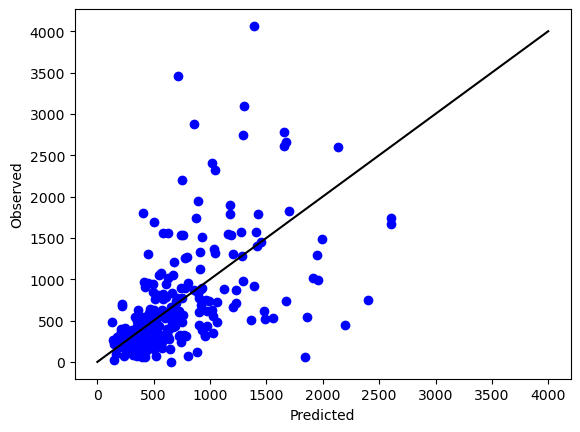

test data correlation coefficient is: 0.5516031629687168
train data correlation coefficient is: 0.9618105831046606


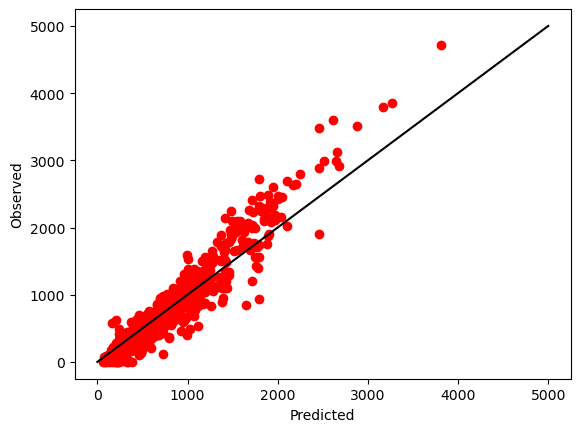

In [7]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 4000], [0, 4000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [10]:
##k-fold cross validation; random forest

predictors = df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin', 'DOY', 'ndvi_augoct',
        'savi_augoct','wdrvi5_augoct','nd_r_g_augoct','nd_g_b_augoct','nd_swir2_nir_augoct', 'nd_swir2_r_augoct',
        'ndvi_sepoct','savi_sepoct','wdrvi5_sepoct','nd_r_g_sepoct','nd_g_b_sepoct', 'nd_swir2_nir_sepoct', 
        'nd_swir2_r_sepoct','ndvi_octnov','savi_octnov','wdrvi5_octnov','nd_r_g_octnov','nd_g_b_octnov',
        'nd_swir2_nir_octnov', 'nd_swir2_r_octnov','ndvi_yr','savi_yr','wdrvi5_yr','nd_r_g_yr','nd_g_b_yr',
        'nd_swir2_nir_yr', 'nd_swir2_r_yr'
    ]
]

targets = df1['Plant_Biomass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
# from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([1.67355418, 1.60276747, 1.69051361, 1.7034986 , 1.66455913]),
 'score_time': array([0.01097178, 0.00997305, 0.01196837, 0.009974  , 0.01196885]),
 'test_r2': array([0.37110599, 0.37810544, 0.39247384, 0.30934803, 0.3534285 ]),
 'test_neg_root_mean_squared_error': array([-394.47923014, -468.73202648, -486.64094338, -502.14311408,
        -539.29622348])}

In [11]:
#Feature importance and average RMSE
x = pd.DataFrame(cv_results)
print(x['test_r2'].mean())
print(x['test_neg_root_mean_squared_error'].mean())
print('NRSME is: ' + str(x['test_neg_root_mean_squared_error'].mean()/np.ptp(yargs_test)))

0.36089235972271533
-478.25830751328857
NRSME is: -0.117751904067113


In [12]:
##Feature selection
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

NameError: name 'forest' is not defined

In [11]:
print(len(yargs))

##More work to do

1343
